#import libraries and load the dataset.

In [18]:
import numpy as np
import pandas as pd

# Load MNIST CSVs (replace with your file paths)
from google.colab import files
uploaded = files.upload()

TRAIN_CSV = "MNIST_train.csv"
TEST_CSV  = "MNIST_test.csv"

train_df_raw = pd.read_csv(TRAIN_CSV)
test_df_raw  = pd.read_csv(TEST_CSV)

print("Train shape:", train_df_raw.shape)
print("Test shape:",  test_df_raw.shape)

display(train_df_raw.head())
display(test_df_raw.head())

Train shape: (60000, 787)
Test shape: (10000, 787)


,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,0,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#Preprocess the Data

In [28]:
# Separate features and labels
X_train = train_df_raw.iloc[:, 3:].values.astype(np.float32)
y_train = train_df_raw.iloc[:, 2].values.astype(int)

X_test = test_df_raw.iloc[:, 3:].values.astype(np.float32)
y_test = test_df_raw.iloc[:, 2].values.astype(int)

# Normalize pixel values
X_train /= 255.0
X_test  /= 255.0

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 60000
Testing samples: 10000


#KNN implementation

In [29]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def knn_predict(X_train, y_train, X_test, k=3):
    preds = []
    for i, x in enumerate(X_test):
        # Compute distances to all training samples
        distances = np.linalg.norm(X_train - x, axis=1)
        # Get indices of k nearest neighbors
        k_idx = np.argsort(distances)[:k]
        # Get the labels of nearest neighbors
        k_labels = y_train[k_idx]
        # Majority vote
        pred = np.bincount(k_labels).argmax()
        preds.append(pred)

        if i % 100 == 0:
            print(f"Processed {i}/{len(X_test)} samples")
    return np.array(preds)


#KNN on small numbers

In [30]:
X_train_small = X_train[:2000]
y_train_small = y_train[:2000]
X_test_small  = X_test[:200]
y_test_small  = y_test[:200]

#Run KNN and measure the time

In [31]:
import time

start = time.time()
y_pred_knn = knn_predict(X_train_small, y_train_small, X_test_small, k=3)
end = time.time()

acc_knn = np.mean(y_pred_knn == y_test_small)
print(f"KNN Accuracy: {acc_knn*100:.2f}%")
print(f"Runtime: {end - start:.2f} seconds")


Processed 0/200 samples
Processed 100/200 samples
KNN Accuracy: 90.50%
Runtime: 0.31 seconds


#Naive Bayes

In [32]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.prior = {}
        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = X_c.mean(axis=0)
            self.var[c] = X_c.var(axis=0) + 1e-6  # avoid zero division
            self.prior[c] = X_c.shape[0] / X.shape[0]

    def _pdf(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(- (x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def predict(self, X):
        preds = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.prior[c])
                likelihood = np.sum(np.log(self._pdf(c, x)))
                posterior = prior + likelihood
                posteriors.append(posterior)
            preds.append(self.classes[np.argmax(posteriors)])
        return np.array(preds)


#train and Evaluate NB

In [33]:
gnb = GaussianNaiveBayes()

start = time.time()
gnb.fit(X_train_small, y_train_small)
y_pred_gnb = gnb.predict(X_test_small)
end = time.time()

acc_gnb = np.mean(y_pred_gnb == y_test_small)
print(f"Naive Bayes Accuracy: {acc_gnb*100:.2f}%")
print(f"Runtime: {end - start:.2f} seconds")


Naive Bayes Accuracy: 60.00%
Runtime: 0.07 seconds


/tmp/ipython-input-3532989454.py:26: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self._pdf(c, x)))


#compare both models

In [34]:
print("=== Results Summary ===")
print(f"KNN Accuracy: {acc_knn*100:.2f}% | Runtime: {end - start:.2f} sec")
print(f"Naive Bayes Accuracy: {acc_gnb*100:.2f}% | Runtime: {end - start:.2f} sec")


=== Results Summary ===
KNN Accuracy: 90.50% | Runtime: 0.07 sec
Naive Bayes Accuracy: 60.00% | Runtime: 0.07 sec


#confusion Matrix

In [35]:
import numpy as np

def confusion_matrix_np(y_true, y_pred, num_classes=10):
    """
    Returns a (num_classes x num_classes) matrix where
    cm[i, j] = count of samples with true label i predicted as j
    """
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm


In [37]:
# === Confusion Matrix Utilities ===
import numpy as np
import matplotlib.pyplot as plt

def confusion_matrix_np(y_true, y_pred, num_classes=10):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

def plot_confusion_matrix(cm, class_names=None, title="Confusion Matrix", highlight_errors=True):
    C = cm.shape[0]
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar(im, label='Count')

    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_xticks(range(C))
    ax.set_yticks(range(C))
    if class_names is not None:
        ax.set_xticklabels(class_names)
        ax.set_yticklabels(class_names)

    # Annotate each cell
    for i in range(C):
        for j in range(C):
            val = cm[i, j]
            color = "white" if im.norm(val) > 0.5 else "black"
            ax.text(j, i, str(val), ha="center", va="center", color=color, fontsize=8)

    # Highlight off-diagonal (misclassifications)
    if highlight_errors:
        for i in range(C):
            for j in range(C):
                if i != j and cm[i, j] > 0:
                    rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                         fill=False, edgecolor='red', linewidth=1.2)
                    ax.add_patch(rect)

    plt.tight_layout()
    plt.show()


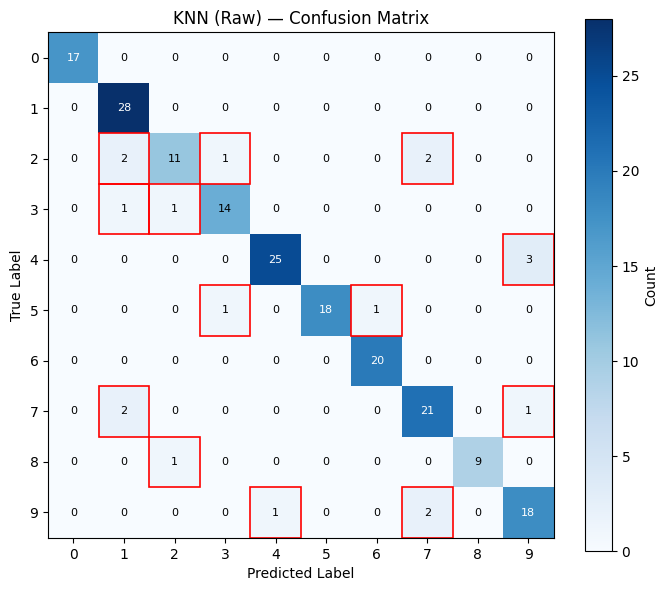

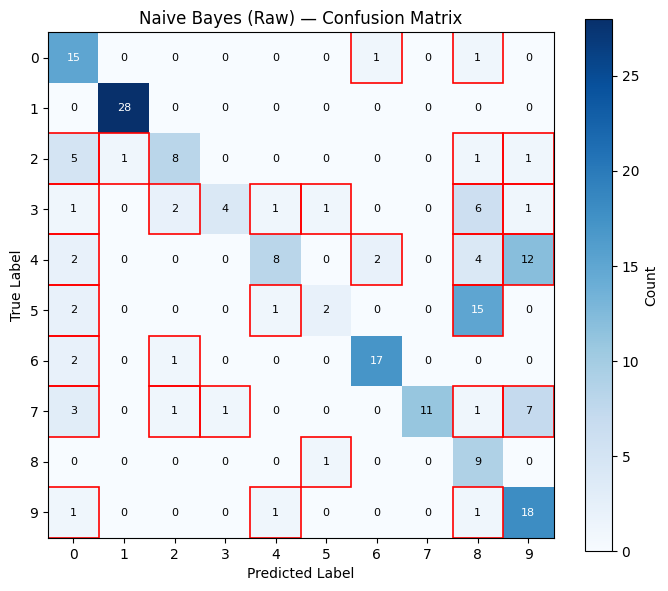

In [39]:
# Example: after running your raw models
# y_pred_knn_raw, y_pred_gnb_raw, y_test_small already exist

digits = [str(i) for i in range(10)]

# KNN (Raw) Confusion Matrix
cm_knn_raw = confusion_matrix_np(y_test_small, y_pred_knn, num_classes=10)
plot_confusion_matrix(cm_knn_raw, class_names=digits, title="KNN (Raw) — Confusion Matrix")

# Naive Bayes (Raw) Confusion Matrix
cm_gnb_raw = confusion_matrix_np(y_test_small, y_pred_gnb, num_classes=10)
plot_confusion_matrix(cm_gnb_raw, class_names=digits, title="Naive Bayes (Raw) — Confusion Matrix")